In [3]:
import os
import math
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


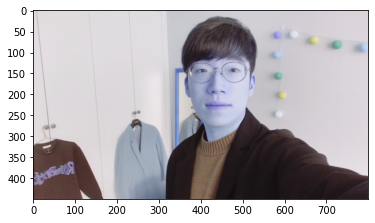

In [4]:
image_file_name = 'image.png' # 나의 사진파일 이름
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'+ image_file_name #이미지 경로설정
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)  # 이미지 대기
plt.show()  # 이미지 표시

In [5]:
detector_hog = dlib.get_frontal_face_detector()  # face detection 할당
print("🌫🛸")

🌫🛸


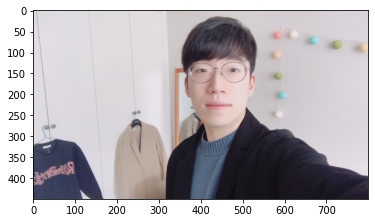

🌫🛸


In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)  # 이미지 대기
plt.show()  # 이미지 표시
dlib_rects = detector_hog(img_rgb, 1)   # (저장된 이미지(변수), num of image pyramid)
print("🌫🛸")

rectangles[[(345, 98) (531, 284)]]


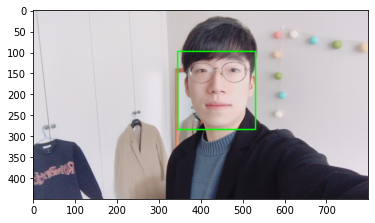

In [7]:
print(dlib_rects)   

for dlib_rect in dlib_rects:  # detector_hog(img_rgb, 1) dlib.rectangle의 객체 left(), top(), right(), bottom(), height(), width()
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)  # cv2로 사각형 그리기

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)  # 수정한 이미지 변환후 저장
plt.imshow(img_show_rgb)  # 이미지 대기
plt.show()  # 이미지 대기

In [8]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat' # 모델 경로설정
landmark_predictor = dlib.shape_predictor(model_path)  #dlib 랜드마크 모델 할당
print("🌫🛸")

🌫🛸


In [9]:
list_landmarks = []

# 얼굴 영역에서 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # 이미지로 face landmark 위치(좌표) 만들기
    temp = list(map(lambda p: (p.x, p.y), points.parts())) # face landmark x, y 좌표를 임시 저장
    list_landmarks.append(temp)  # temp로 임시저장된 좌표를 0번인덱스에 한꺼번에 넣기!
    
print(len(list_landmarks[0]))

68


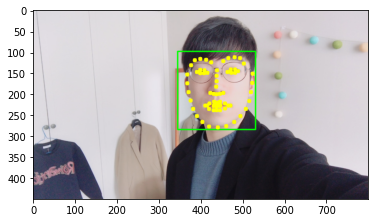

In [10]:
for i in range(len(list_landmarks[0])):  # 점을 랜드마크 갯수만큼 찍어줘야 함!
        x, y = list_landmarks[0][i]  # 저장해둔 좌표값 써먹기.
        cv2.circle(img_show, (x, y), 5, (0, 255, 255), -1)  # 이미지에 좌표에 따라 점 찍기

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)  # 수정한 이미지 변환후 저장
plt.imshow(img_show_rgb)  # 이미지 대기
plt.show()  # 이미지 출력

In [12]:

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):  # zip 함수를 통해 동시에 두가지 list 불러오기 
    angle = math.atan((landmark[19][1] - landmark[24][1]) / (landmark[19][0] - landmark[24][0])) * 180 / math.pi # 얼굴 기울기 계산을 위해
    x = landmark[33][0]  # 이미지를 표시할 좌표 x
    y = landmark[33][1] + (landmark[51][1]-landmark[33][1]) // 2 - 5  # 이미지를 표시할 좌표 y (이미지 높이를 33과 51사이에 넣기 위해 좌표값을 빼고 나눔)
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (438,205)
(w,h) : (187,187)


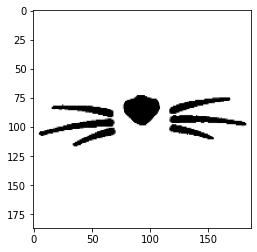

In [13]:
# 스티커 이미지 경로
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
sticker_path_rotated = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers_rotated.png'
# 이미지 손실없이 회전위해 PIL로 불러와서 회전한 이미지를 다시 저장
img_sticker = Image.open(sticker_path) # 경로에서 이미지 불러오기
img_sticker = img_sticker.rotate(-angle,fillcolor='white', expand=True)  # 회전과 배경 채우기
img_sticker.save(sticker_path_rotated)  # 저장

img_sticker = cv2.imread(sticker_path_rotated) # 스티커 이미지를 다시 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 이미지 크기 조절하기


plt.imshow(img_sticker)
plt.show()

In [14]:
# 이미지의 왼쪽 위가 랜드마크의 좌표로 설정 되어 있기 때문에 이미지 x, y 재설정
# 이미지가 중간이 좌표의 중간과 일치하도록 위치 설정.
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (345,112)


In [15]:
# 이미지 위치가 음수일 경우 이미지를 자름
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

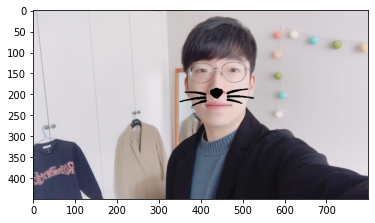

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()